In [3]:
import numpy as np
import pdb

from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [4]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [101]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest

sigma1 = 1
sigma0 = 4

# number of data points
# TODO: run code with n=100000 
n = 1000

## Generate observed data

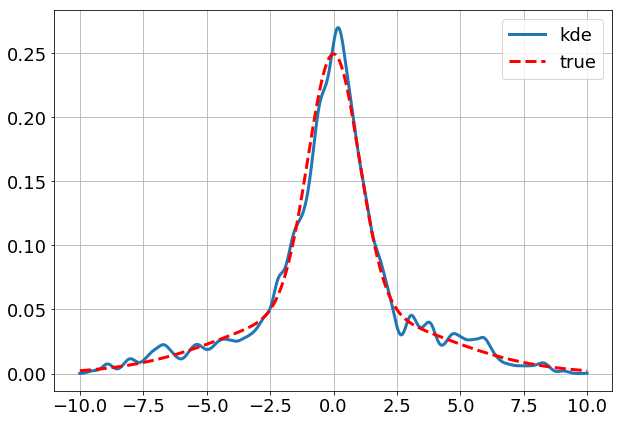

In [102]:
z = rnd.uniform(0,1, n) > 0.5

x = ((z==0)*(rnd.randn(n)*sigma0) + (z==1)*(rnd.randn(n)*sigma1)).reshape(-1,1)

# check
fig = plt.figure(figsize=(10,7))
u = np.arange(-10,10,0.01).reshape(-1,1)

x_density = kd(bandwidth=0.2).fit(x)
x_density_samples = np.exp(x_density.score_samples(u))
plt.plot(u, x_density_samples, label='kde')

px = 0.5*(norm.pdf(u,0,sigma0)+norm.pdf(u,0,sigma1))
plt.plot(u, px, label='true', c='r', linestyle = '--')

plt.legend()
plt.grid()

## NCE objective function 

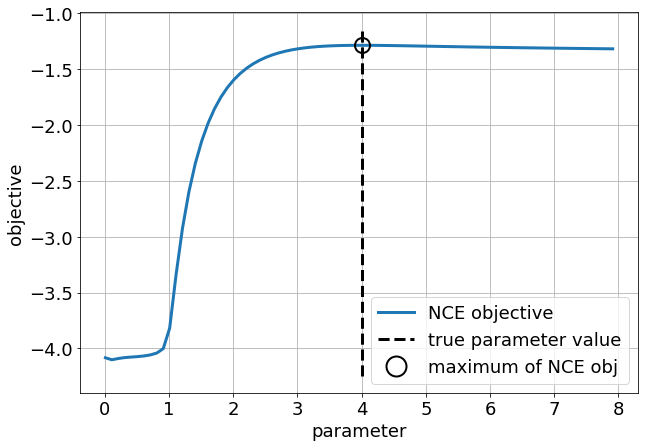

In [157]:
# nu is the ratio of noise to data samples
nu = 1

thetas = np.arange(0.01, 8, 0.1)

# correctly normalised model
pm = lambda u, theta: 0.5*(norm.pdf(u,0,theta)+norm.pdf(u, 0, sigma1))

pn = lambda u: norm.pdf(u,0, sigma0) # noise that matches the larger std

h = lambda u, theta: np.log(pm(u, theta)/pn(u)) # quick hack: generally better to work in log domain!

y = sigma0 * rnd.randn(n*nu)

n_theta = len(thetas)
J = np.zeros(n_theta)

for k in range(n_theta):
    theta_k = thetas[k]
    J[k] = -np.mean( np.log(1 + nu*np.exp(-h(x,theta_k))) ) - nu* np.mean( np.log(1 + 1/nu*np.exp(h(y,theta_k))) )


fig = plt.figure(figsize=(10,7))

plt.plot(thetas,J, label='NCE objective')
plt.plot(sigma0*np.array([1, 1]), plt.get(fig.gca(),'ylim'),'k--', label='true parameter value')

index = np.argmax(J)
plt.plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj')

plt.xlabel('parameter')
plt.ylabel('objective')

plt.grid()
lgd = plt.legend(loc='best', numpoints=1)
lgd.legendHandles[2]._legmarker.set_markersize(20)

## First lower bound

In [112]:
eps = 10**-15

#q0 = lambda u, alpha:  1 / (1 + (alpha/sigma1)*np.exp(-((u**2)/2)*(1/sigma1**2 - 1/alpha**2)))
q0 = lambda u, alpha: norm.pdf(u, 0, alpha) / (norm.pdf(u, 0, alpha) + norm.pdf(u, 0, sigma1))
q1 = lambda u, alpha: 1 - q0(u, alpha) 

phi0 = lambda u, theta:  0.5*norm.pdf(u, 0, theta)
phi1 = lambda u, theta:  0.5*norm.pdf(u, 0, sigma1)

r0 = lambda u, theta, alpha: phi0(u, theta)/( q0(u, alpha)*pn(u) + eps)
r1 = lambda u, theta, alpha: phi1(u, theta)/( q1(u, alpha)*pn(u) + eps)
r = lambda u, z, theta, alpha: (z==0)*r0(u, theta, alpha) + (z==1)*r1(u, theta, alpha)

In [113]:
def compute_J1(x, y, zx, zy, theta, alpha):
    # compute expectation for 2nd term of J1
    m = q0(y,alpha)*r0(y,theta, alpha) + q1(y, alpha)*r1(y,theta, alpha)

    # J1 objective
    J1 = -np.mean(np.log(1 + (nu/(r(x, zx, theta, alpha) + eps)))) \
         - nu*np.mean( np.log(1 + (1/nu)*r(y, zy, theta, alpha)))
         #- nu*np.mean( np.log(1 + (1/nu)*m)) 
    return J1

In [153]:
J1 = np.zeros(n_theta)
J1_sigma0 = np.zeros(n_theta)

for k in range(n_theta):
    theta_k = thetas[k]
    
    # generate 'missing data' using variational q distribution
    zx = rnd.uniform(0, 1, n) < q1(x, theta_k) # shape (n, n)
    zy = rnd.uniform(0, 1, n) < q1(y, theta_k)
    zx_2 = rnd.uniform(0, 1, n) < q1(x, sigma0)
    zy_2 = rnd.uniform(0, 1, n) < q1(y, sigma0)
    
    # compute two types of lower bound
    J1[k] = compute_J1(x, y, zx, zy, theta_k, theta_k)
    J1_sigma0[k] = compute_J1(x, y, zx_2, zy_2, theta_k, sigma0)

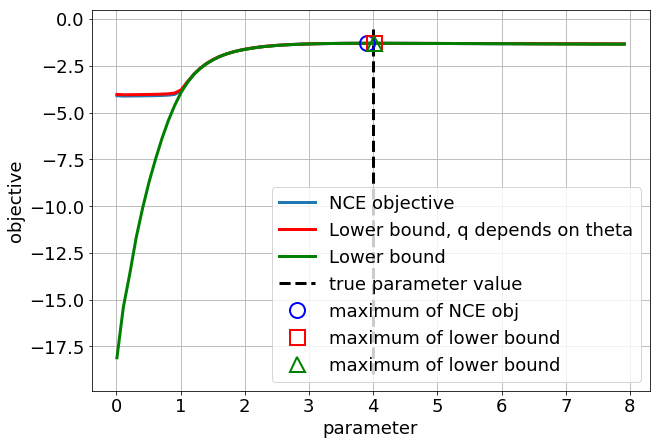

In [154]:
fig = plt.figure(figsize=(10, 7))
plt.plot(thetas, J, label='NCE objective')
plt.plot(thetas, J1, 'r', label='Lower bound, q depends on theta')
plt.plot(thetas, J1_sigma0, 'g', label='Lower bound')

# true param value
plt.plot(sigma0 * np.array([1,1]), plt.get(fig.gca(),'ylim'), 'k--', label='true parameter value')

# maximiser of NCE obj
plt.plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')

index1 = np.argmax(J1)
# maximiser of lower bound
plt.plot(thetas[index1], J1[index1], 'rs', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='r', linestyle='none', label='maximum of lower bound')

index2 = np.argmax(J1_sigma0)
# maximiser of lower bound
plt.plot(thetas[index2], J1[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='maximum of lower bound')

"""
plt.plot(theta,Jlower,'g', label='lb w/o importance sampling')
index2 = np.argmax(Jlower)
# maximiser of lower bound (before importance sampling)
plt.plot(theta[index2], Jlower[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='max of lb w/o importance sampling')
"""

plt.xlabel('parameter')
plt.ylabel('objective')
plt.legend(loc='lower right', numpoints=1)
plt.grid()

In [116]:
print('J1 is a numerical lower bound for {}% of the parameters'.format(100* np.sum(J1_sigma0 < J) / J.size))

J1 is a numerical lower bound for 86.25% of the parameters


## Using EM-type procedure to maximize J1

For a simple initial experiment, we will iterate between optimising $\theta$ (for a fixed q), and resetting q to be:

$$ q_k := q(\theta_k) = \left(  1 + \frac{\theta_k}{\sigma_1} \exp \left(\frac{- u^2}{2} \left( \frac{1}{\sigma_1^2} - \frac{1}{\theta_k^2} \right) \right) \right)^{-1} $$

Given such a $q_k$, we can find the next $\theta_{k+1}$ by maximising the lower bound on the NCE objective:

\begin{align}
J_1^k(\theta) = \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \left[ \log(1 + \frac{\nu}{r(x, z; \theta)}) \right]} - \color{blue}{ \nu \mathbb{E}_{y}  \left[ \log(1 + \frac{1}{\nu} \mathbb{E}_{z \sim q_k}[r(y, z; \theta)] ) \right]}
\end{align}

where 

$$ r(u,z, \theta) = \frac{\phi(u, z; \theta)}{q_k(z \ | \ u) p_y(u)}$$


Note that q here is *not* a function of theta.

To find the argmax of $J_1^K(\theta)$, we need to differentiate it. To do so, let us first further reduce the notational burden, by writing:

\begin{align}
J_1^k(\theta) & =  \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \left[ \log(\psi_1(x, z; \theta)) \right]} -       \color{blue}{ \nu \mathbb{E}_{y}  \left[  \log(\psi_2(y; \theta)) \right]} \\
\end{align}

Where the terms of the same colour are equivalent to each other.

Now, let us take derivative with respect to $\theta$:

\begin{align}
\color{red}{ \nabla_{\theta} \log(\psi_1(x, z; \theta))} & = \frac{1}{\psi_1(x, z; \theta)} \nabla_{\theta} \psi_1(x, z; \theta) \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \nabla_{\theta} r(x, z; \theta) \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \frac{\nabla_{\theta} \phi(x, z; \theta)}{q_k(z \ | \ x)p_y(x)}
\end{align}

Hence, we need:

\begin{align}
\nabla_{\theta} \phi(x, z; \theta) & = \nabla_{\theta} \exp ( \log ( \phi(x, z; \theta) ) ) \\
& = \left[ \nabla_{\theta} \log(\phi(x, z; \theta)) \right] \exp ( \log ( \phi(x, z; \theta) ) )\\
& = \left[ \nabla_{\theta} \left(-\log(\theta) - \frac{x^2}{2 \theta^2} \right) \right] \phi(x, z; \theta) \\
& = \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \phi(x, z; \theta)
\end{align}

Plugging this back in, we get:

\begin{align}
\color{red}{ \nabla_{\theta} \log(\psi_1(x, z; \theta))} & = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \frac{\left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \phi(x, z; \theta)}{q_k(z \ | \ x)p_y(x)} \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \\
& = \color{red}{-\nu \frac{\psi_1(x, z; \theta) - 1}{\psi_1(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right]} \\
\end{align}

Where in the final line we used the fact that $\color{red}{\psi_1(x, z; \theta) - 1 = \frac{1}{r(x, z; \theta)}}$.

Now we find the derivative of the second (blue) term of $J_1^K(\theta)$. Recalling that $\color{blue}{\psi_2(y; \theta) = 1 + \frac{1}{\nu} \mathbb{E}_{z \sim q_k}[r(y, z; \theta)]}$, we have:

\begin{align}
\color{blue}{\nabla_{\theta} \log(\psi_2(y; \theta))} & = \frac{1}{\psi_2(y; \theta)} \nabla_{\theta} \psi_2(y; \theta) \\
& = \frac{1}{\psi_2(y; \theta)} \frac{1}{\nu} \mathbb{E}_{z \sim q_k} \left[ \frac{\nabla_{\theta} \phi(y, z; \theta)}{q_k(z \ | \ y)p_y(y)} \right] \\
& = \frac{1}{\psi_2(y; \theta)} \frac{1}{\nu} \mathbb{E}_{z \sim q_k} \left[ r(y, z; \theta) \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right] \right] \\
& = \color{blue}{\frac{\psi_2(y; \theta) - 1}{\psi_2(y; \theta)} \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right]}
\end{align}

Putting this all together, we arrive at: 

\begin{align}
\nabla_{\theta}(J_1^k(\theta)) & =  \color{red}{\nu \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \frac{\psi_1(x, z; \theta) - 1}{\psi_1(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right]} + \color{blue}{ -\nu \mathbb{E}_{y}  \frac{\psi_2(y; \theta) - 1}{\psi_2(y; \theta)} \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right]} \\
\end{align}

In [117]:
def psi_1(x, z, theta, alpha):
    return 1 + (1 / r(x, z, theta, alpha))

def psi_2(y, z, theta, alpha):
    return 1 + (1/nu)*r(y, zy, theta, alpha)

In [118]:
def J1_grad(x, y, zx, zy, theta, alpha):
    '''Computes J1_grad as defined in the equations above. NOTE: we use a 1-sample MC estimate
    for the expectation w.r.t to q'''
    
    term_1 = nu*np.mean(((psi_1(x, zx, theta, alpha) - 1)/psi_1(x, zx, theta, alpha))*(-(1/theta) + (x**2/theta**3)))
    term_2 = -nu*np.mean(((psi_2(y, zy, theta, alpha) - 1)/psi_2(y, zy, theta, alpha))*(-(1/theta) + (y**2/theta**3)))
    
    return term_1 + term_2

In [159]:
opt_thetas = []
J1s = []

theta_k = np.array([1])
opt_thetas.append(theta_k)
J1s.append(compute_J1(x, y, zx, zy, theta_k[0], theta_k))

prev_J1 = -999
current_J1 = -9999

while np.abs(prev_J1 - current_J1) > 10**-6:
    # update the q distribution
    q_k_0 = lambda u: q0(u, theta_k)
    q_k_1 = lambda u: 1 - q_k_0(u)
    
    # sample from q(z|x) and q(z|y)
    zx = rnd.uniform(0,1, n) < q1(x, theta_k)
    zy = rnd.uniform(0,1, n) < q1(y, theta_k)
    
    J1_k = lambda theta: compute_J1(x, y, zx, zy, theta[0], theta_k)
    J1_k_grad = lambda theta: np.array([J1_grad(x, y, zx, zy, theta[0], theta_k)])
    
    J1_k_neg = lambda theta: -J1_k(theta)
    J1_k_grad_neg = lambda theta: -J1_k_grad(theta)
    
    res = minimize(J1_k_neg, theta_k, method='BFGS', jac=J1_k_grad_neg,
                   options={'disp': True})
    
    prev_J1 = J1_k(theta_k)
    theta_k = res.x
    current_J1 = J1_k(theta_k)
    
    # store results
    opt_thetas.append(theta_k)
    J1s.append(current_J1)

opt_thetas = np.array(opt_thetas).flatten()
J1s = np.array(J1s)

         Current function value: 2.617938
         Iterations: 9
         Function evaluations: 110
         Gradient evaluations: 98
         Current function value: 1.287474
         Iterations: 5
         Function evaluations: 102
         Gradient evaluations: 90
         Current function value: 1.285586
         Iterations: 0
         Function evaluations: 90
         Gradient evaluations: 78


In [160]:
opt_thetas, J1s

(array([ 1.        ,  3.05302967,  3.93452952,  3.93452952]),
 array([-3.79166672, -1.361957  , -1.28558627, -1.28558627]))

In [161]:
lower_bounds = [np.zeros(n_theta) for i in range(len(opt_thetas))]
for i in range(len(lower_bounds)):
    alpha = opt_thetas[i]

    q_0 = lambda u: q0(u, alpha)
    q_1 = lambda u: 1 - q_0(u)

    # generate 'missing data' using variational q distribution
    zx = rnd.uniform(0, 1, n) < q1(x, alpha) # shape (n, n)
    zy = rnd.uniform(0, 1, n) < q1(y, alpha)
    
    for j in range(n_theta):
        # compute lower bound
        lower_bounds[i][j] = compute_J1(x, y, zx, zy, thetas[j], alpha)

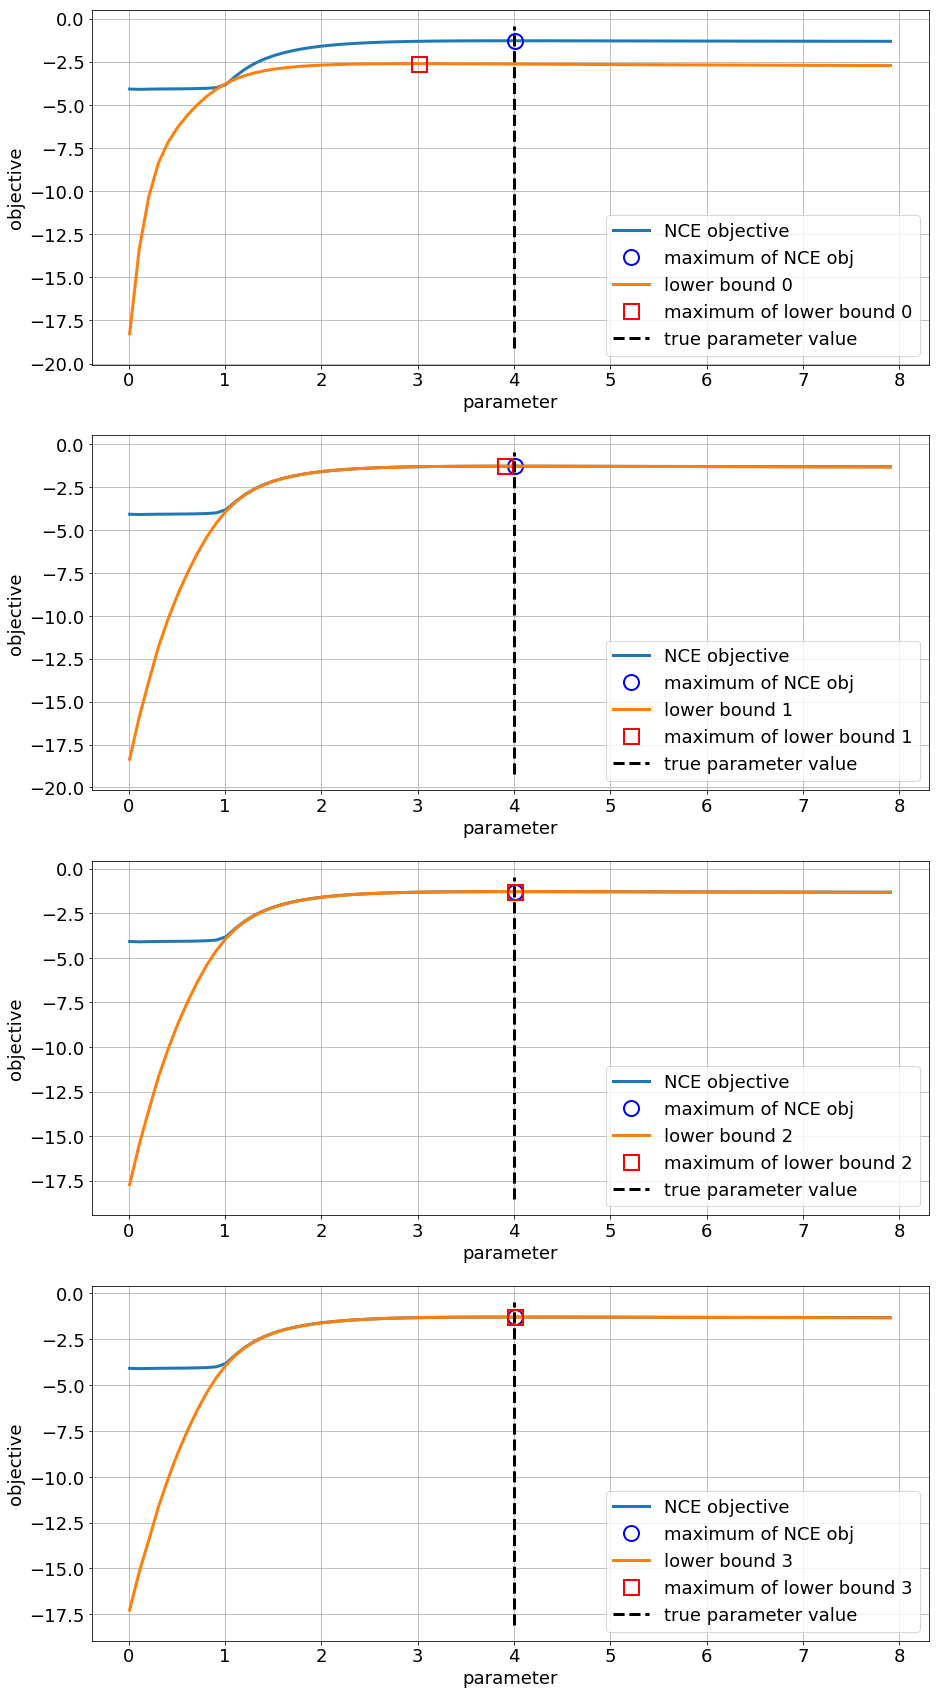

In [162]:
fig, axs = plt.subplots(len(lower_bounds), 1, figsize=(15, 30))
axs = axs.ravel()
for i in range(len(lower_bounds)):
    
    # plot NCE objective and its maximum
    axs[i].plot(thetas, J, label='NCE objective')
    axs[i].plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')
    
    lb = lower_bounds[i]
    axs[i].plot(thetas, lb, label='lower bound {}'.format(i))
   
    lb_index = np.argmax(lb)
    # maximiser of lower bound
    axs[i].plot(thetas[lb_index], lb[lb_index], 'rs', markersize=15, fillstyle='none', 
             markeredgewidth=2, linestyle='none', label='maximum of lower bound {}'.format(i))
    
    # true param value
    axs[i].plot(sigma0 * np.array([1,1]), plt.get(axs[i],'ylim'), 'k--', label='true parameter value')

    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()

## Using variational EM-type procedure to maximize J1

Now we try using a variational q distribution of the form:

$$ q(u; \textbf{w}) = \sigma(w_0 + w_1u + w_2u^2) $$

where $\sigma$ is the sigmoid function and $\textbf{w}$ are the variational parameters. We will then alternate optimisation of $\theta$ and $\textbf{w}$ (i.e apply a form of coordinate ascent).